In [1]:
# # comment when run locally
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My\ Drive/similar_faces/

In [2]:
# # uncomment when run locally
# !rm -rf /data_celeba
# !mkdir /data_celeba
# %cp celeba_identity.txt /data_celeba
# %cp img_align_celeba.zip /data_celeba
# %cd /data_celeba
# !unzip -q img_align_celeba.zip
# %ls

In [3]:
import time
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torchvision.utils import make_grid
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
%matplotlib inline

In [4]:
if torch.cuda.is_available():
    print(f'Cuda device: {torch.cuda.get_device_name(0)}')
else:
    print('Cuda unavailable')

Cuda unavailable


## Dataset

In [5]:
class SimilarFaceDatasetOnline(Dataset):
    def __init__(self, n_classes, n_samples, train_test_split=0.95, is_train=True):
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.transform = transforms.ToTensor()
        
        with open('celeba_identity.txt') as f:
            filename_identity = [x.split() for x in f.readlines()]

        identity_filenames_dict = defaultdict(list)
        for i in filename_identity:
            identity_filenames_dict[int(i[1])].append(i[0])

        identity_filenames_list = list(filter(lambda x: len(x) > n_samples, (map(lambda x: x[1], sorted(identity_filenames_dict.items(), key=lambda x: x[0])))))
        train_test_split_index = int(0.95 * len(identity_filenames_list))
        if is_train:
            self.identity_filenames_list = identity_filenames_list[:train_test_split_index]
        else:
            self.identity_filenames_list = identity_filenames_list[train_test_split_index:]
            
    def __len__(self):
        return len(self.identity_filenames_list) // self.n_classes
    
    def __getitem__(self, index):
        return torch.stack([self.transform(Image.open(f'img_align_celeba/{x}')) for xs in random.sample(self.identity_filenames_list, n_classes) for x in random.sample(xs, n_samples)])


## Network

In [6]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            residual = self.downsample(residual)
            
        x += residual
        x = F.relu(x)
        
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, out_channels=10):
        super().__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], 2)
        self.layer3 = self._make_layer(block, 64, layers[2], 2)
        self.layer4 = self._make_layer(block, 128, layers[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, out_channels)
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_net = ResNet(ResidualBlock, [2, 2, 2, 2], out_channels=10)
        
    def get_embedding(self, x):
        return self.embedding_net(x)
        
    def forward(self, a, p, n):
        a_out = self.embedding_net(a)
        p_out = self.embedding_net(p)
        n_out = self.embedding_net(n)
        return (a_out, p_out, n_out)

## Util function

In [7]:
def anchor_positive_pairs(n_classes, n_samples):
    for positive_class in range(n_classes):
        for anchor in range(n_samples):
            for positive in range(n_samples):
                if anchor != positive:
                    yield positive_class * n_samples + anchor, positive_class * n_samples + positive

def all_triplets(n_classes, n_samples):
    for positive_class in range(n_classes):
        for negative_class in range(n_classes):
            if positive_class != negative_class:
                for anchor in range(n_samples):
                    for positive in range(n_samples):
                        if anchor != positive:
                            for negative in range(n_samples):
                                yield (positive_class * n_samples + anchor,
                                       positive_class * n_samples + positive,
                                       negative_class * n_samples + negative)

def get_triplets(embeddings, margin, mode='random_hard_negative'):
    triplets = []
    pdist = pairwise_distances(embeddings)
    for a, p in anchor_positive_pairs(n_classes, n_samples):
        positive_class = a // n_samples
        dap = pdist[a, p]
        dan = pdist[a, :].copy()
        dan[positive_class*n_samples:(positive_class+1)*n_samples] = np.inf

        loss = dap - dan + margin

        # hardest negative
        hardest_negative_index = np.argmax(loss)
        
        if mode == 'hardest_negative':
            triplets.append([a, p, hardest_negative_index])
            continue

        # random hard negative
        hard_negatives = np.where(loss > 0)[0]
        random_hard_negative_index = np.random.choice(hard_negatives) if len(hard_negatives) > 0 \
                                                                    else hardest_negative_index

        triplets.append([a, p, random_hard_negative_index])
    return np.array(triplets)

## Preparation

In [8]:
n_epochs = 100
n_classes = 10
n_samples = 4
margin = 1.0
learning_rate = 0.001

train_dataset = SimilarFaceDatasetOnline(n_classes=n_classes, n_samples=n_samples, is_train=True)
test_dataset = SimilarFaceDatasetOnline(n_classes=n_classes, n_samples=n_samples, is_train=False)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)

# Loss and optimizer
criterion = torch.nn.TripletMarginLoss(margin=margin)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [10]:
# Load checkpoint
checkpoint = torch.load('checkpoint_online', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
# model.train()
# num_step_to_print_info = 100
# total_step = len(train_loader)
# train_avg_loss = 0

# for epoch in range(n_epochs):
#     for step, batch in enumerate(train_loader):
#         # forward pass
#         embeddings = model.get_embedding(batch.squeeze(0).to(device))

#         triplets = get_triplets(embeddings.detach().to('cpu').numpy(), margin, mode='random_hard_negative')
#         # triplets = np.array(list(all_triplets(n_classes, n_samples))) # all triplets
#         loss = criterion(
#             embeddings[triplets[:, 0]], 
#             embeddings[triplets[:, 1]],
#             embeddings[triplets[:, 2]]
#         )
#         train_avg_loss += loss.item()

#         # backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (step + 1) % num_step_to_print_info == 0:
#             train_avg_loss /= num_step_to_print_info
#             print(f'Epoch [{epoch+1}/{n_epochs}], Step [{step+1}/{total_step}], Train avg loss: {train_avg_loss:.4f}')
#             train_avg_loss = 0
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict()
#                 }, '/gdrive/My Drive/similar_faces/checkpoint_online')

## Test on custom data

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
Explained variance ratio: [0.33371216 0.21882288]


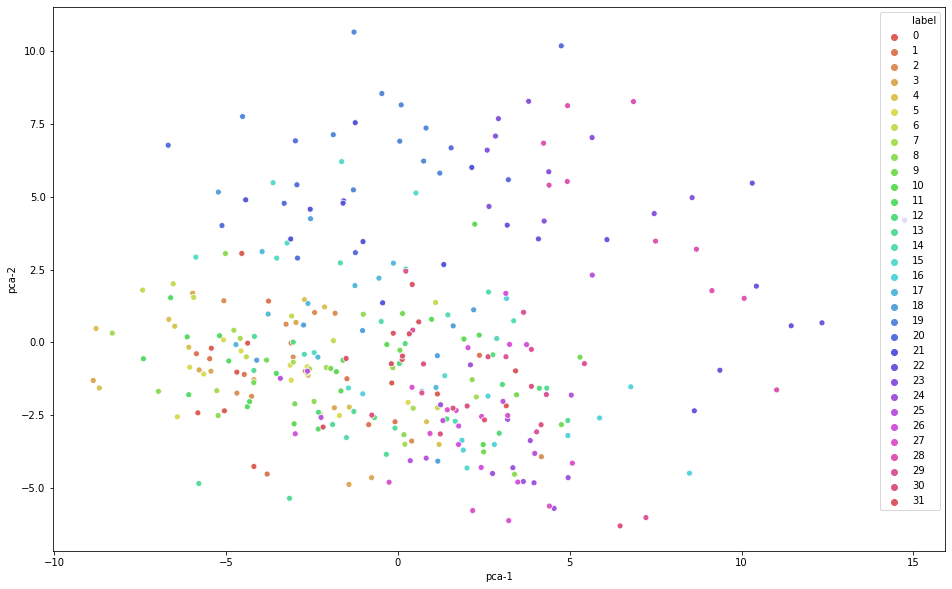

In [12]:
model.eval()
count = 32
transform = transforms.Compose([
    transforms.Resize((217, 178)),
    transforms.ToTensor(),
    lambda x: x[:3]
])

images = torch.empty(320, 3, 217, 178)
j = 0
for i in range(count):
    pathname = os.path.join('./data', f'c{i+1}')
    for filename in glob.glob(f'{pathname}/*'):
        images[j] = transform(Image.open(filename))
        j += 1
    print(f'{i} ', end='')

embeddings = model.get_embedding(images).detach().numpy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
df = pd.DataFrame()
df['pca-1'] = pca_result[:, 0]
df['pca-2'] = pca_result[:, 1]
df['label'] = [i for i in range(count) for j in range(10)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pca-1', 
    y='pca-2',
    hue='label',
    palette=sns.color_palette("hls", count),
    data=df
)
print(f'\nExplained variance ratio: {pca.explained_variance_ratio_}')

[ 0.        10.002769  12.5349455 17.458246  22.077398  22.800747
 25.803532  26.082516  27.257397  29.978981 ]


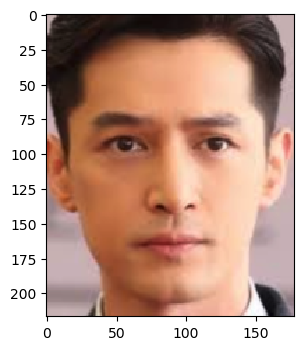

In [13]:
target_face_index = 24
k = 10
l2_distances = ((embeddings[target_face_index] - embeddings) ** 2).sum(axis=1)
closest_k_face_indices = np.argsort(l2_distances)[:k]
closest_k_faces = images[closest_k_face_indices]
print(l2_distances[closest_k_face_indices])

plt.figure(dpi=100)
plt.imshow(np.transpose(images[target_face_index], (1, 2, 0)))

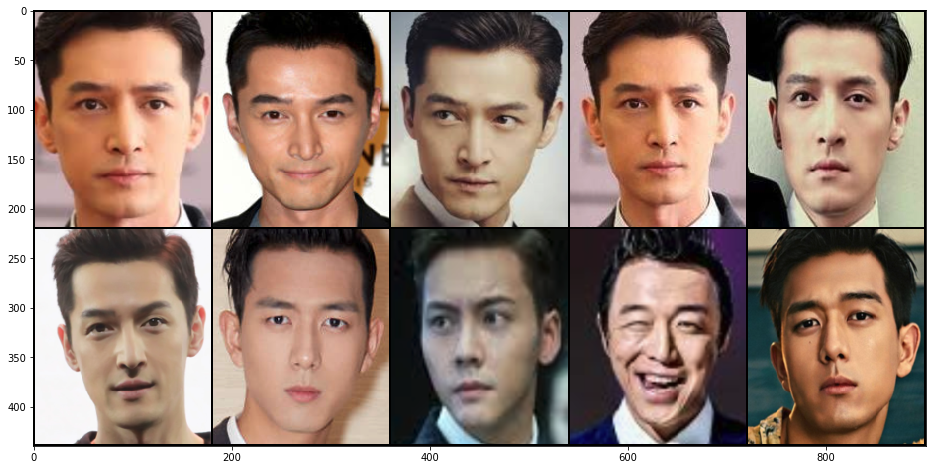

In [14]:
plt.figure(figsize=(16, 10))
plt.imshow(np.transpose(make_grid(closest_k_faces, 5), (1, 2, 0)))

## Test on celeba data


Explained variance ratio: [0.3522506  0.17505158]


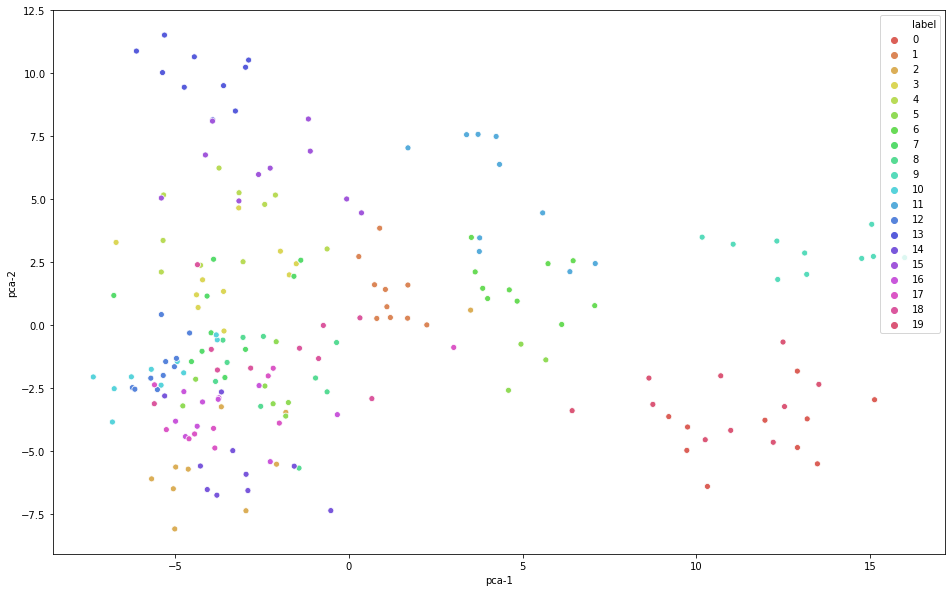

In [15]:
model.eval()
count = 20
with open('celeba_identity.txt') as f:
    filename_identity = [x.split() for x in f.readlines()]
    identity_filenames_dict = defaultdict(list)
    for i in filename_identity:
        identity_filenames_dict[int(i[1])].append(i[0])
    identity_filenames_list = []
    for i in range(len(identity_filenames_dict)):
        tmp = []
        for filename in identity_filenames_dict[i+1]:
            tmp.append(filename)
        if len(tmp) >= 10:
            identity_filenames_list.append(tmp[:10])
    mask = random.sample(range(len(identity_filenames_list)), count)
    identity_filenames_list_ = []
    for i in mask:
        identity_filenames_list_.append(identity_filenames_list[i])    
    transform = transforms.ToTensor()

images = []
for i in range(count):
    tmp = []
    for j in range(10):
        filename = identity_filenames_list[-i][j]
        images.append(transform(Image.open(f'./img_align_celeba/{filename}')))
images = torch.stack(images)

embeddings = model.get_embedding(images)
embeddings = embeddings.detach().numpy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
df = pd.DataFrame()
df['pca-1'] = pca_result[:, 0]
df['pca-2'] = pca_result[:, 1]
df['label'] = [i for i in range(count) for j in range(10)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pca-1', 
    y='pca-2',
    hue='label',
    palette=sns.color_palette("hls", count),
    data=df
)
print(f'\nExplained variance ratio: {pca.explained_variance_ratio_}')

[ 0.       14.000887 14.874135 17.936405 28.464441 34.34486  34.61184
 36.587444 52.049618 57.1764  ]


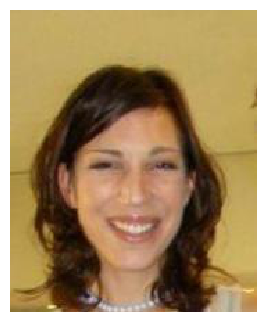

In [16]:
target_face_index = 10
k = 10
l2_distances = ((embeddings[target_face_index] - embeddings) ** 2).sum(axis=1)
closest_k_face_indices = np.argsort(l2_distances)[:k]
closest_k_faces = images[closest_k_face_indices]
print(l2_distances[closest_k_face_indices])

plt.figure(dpi=100)
plt.axis('off')
plt.imshow(np.transpose(images[target_face_index], (1, 2, 0)))

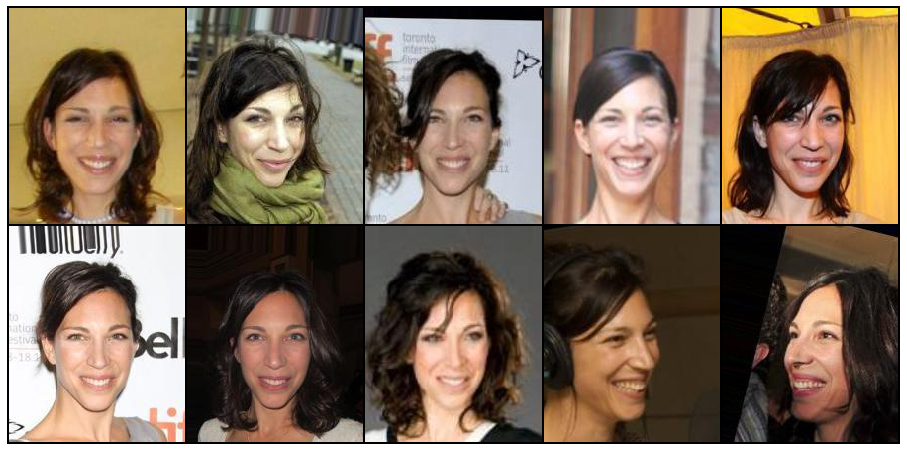

In [17]:
plt.figure(figsize=(16, 10))
plt.axis('off')
plt.imshow(np.transpose(make_grid(closest_k_faces, 5), (1, 2, 0)))